In [1]:
# import needed python libraries

%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

import plotly.offline as py 
import plotly.express as px
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.subplots as tls # It's useful to we get some tools of plotly
from plotly.subplots import make_subplots
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, confusion_matrix,  mean_squared_error, mean_absolute_error, accuracy_score, RocCurveDisplay, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier 

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from collections import Counter # To do counter of some features

import torch
from torch import nn
import torch.nn.functional as F

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# matplotlib defaults
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True)
plt.rc("figure", figsize=(12, 6))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

#### this code, allow us to work with offline plotly version
py.init_notebook_mode(connected=True) 

#### to avoid some redundant warning during cross-validation due to parameters incompatibility and also eventual packets'versions mismatch
import warnings
warnings.filterwarnings('ignore')

#### List of Attributes for dataset acquired from german.doc
#### good/bad is the label 1 means good customer while 2 means bad
attributes = ["Status_account", "Duration", "Credit_history","Purpose",
             "Credit_amount","Savings_account_bonds","Employment_since","Install_rate",
              "Personal_status_sex","debtors_guarantors","Present_residence_since",
              "Property","Age","Other_install_plans","Housing","No_credits","Job",
              "No_people_liable","Telephone","foreign_worker","good_bad"] 

#### Acquiring dataset from german.data file
df_credit = pd.read_csv("statlog+german+credit+data/german.data", sep=' ', names = attributes)

d:\WINDOWS\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



### We use df_credit for the Exploratory Data Analysis

### 1.3 Exploratory Data Analysis ###
---
Delve into the dataset’s patterns using various visualization techniques, such as histograms of average
values, scatter plots of most interesting features and correlation matrices. Provide insights into under-
lying patterns and, most importantly, identify features significantly influencing loan risk classification

# **Some explorations:** <a id="Explorations"></a> <br>

- Starting by distribuition of column Age.
- Some Seaborn graphical
- Columns crossing



## Let's start looking through target variable and their distribuition

## 1.3.1 Numerical Features

In [2]:
df_credit['good_bad'] = df_credit['good_bad'].replace([1],'Good')
df_credit['good_bad'] = df_credit['good_bad'].replace([2],'Bad')
#Counts the number of Good and Bad
trace0 = go.Bar(
            x = df_credit[df_credit["good_bad"]== 'Good']["good_bad"].value_counts().index.values,
            y = df_credit[df_credit["good_bad"]== 'Good']["good_bad"].value_counts().values,
            name='Good credit'
    )

trace1 = go.Bar(
            x = df_credit[df_credit["good_bad"]== 'Bad']["good_bad"].value_counts().index.values,
            y = df_credit[df_credit["good_bad"]== 'Bad']["good_bad"].value_counts().values,
            name='Bad credit'
    )

data = [trace0, trace1]


layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='Risk Variable'
    ),
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')

### Age

Age is a numeric column. The minimum age in the dataset is 19 and the maximum age is 75. Thus, we can visualize the distribution of age using a histogram with 56 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [3]:
df_credit.Age.describe()

count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: Age, dtype: float64

In [4]:
fig = px.histogram(df_credit, 
                   x='Age', 
                   marginal='box', 
                   nbins=56, 
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()

In [5]:
df_good = df_credit.loc[df_credit["good_bad"] == 'Good']['Age'].values.tolist()
df_bad = df_credit.loc[df_credit["good_bad"] == 'Bad']['Age'].values.tolist()
df_age = df_credit['Age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

In [6]:
fig = px.histogram(df_credit, 
                   x='Age', 
                   marginal='box', 
                   color='good_bad', 
                   color_discrete_sequence=['blue', 'red'], 
                   title='Age Distribution for Good or Bad creditors')
fig.update_layout(bargap=0.1)
fig.show()

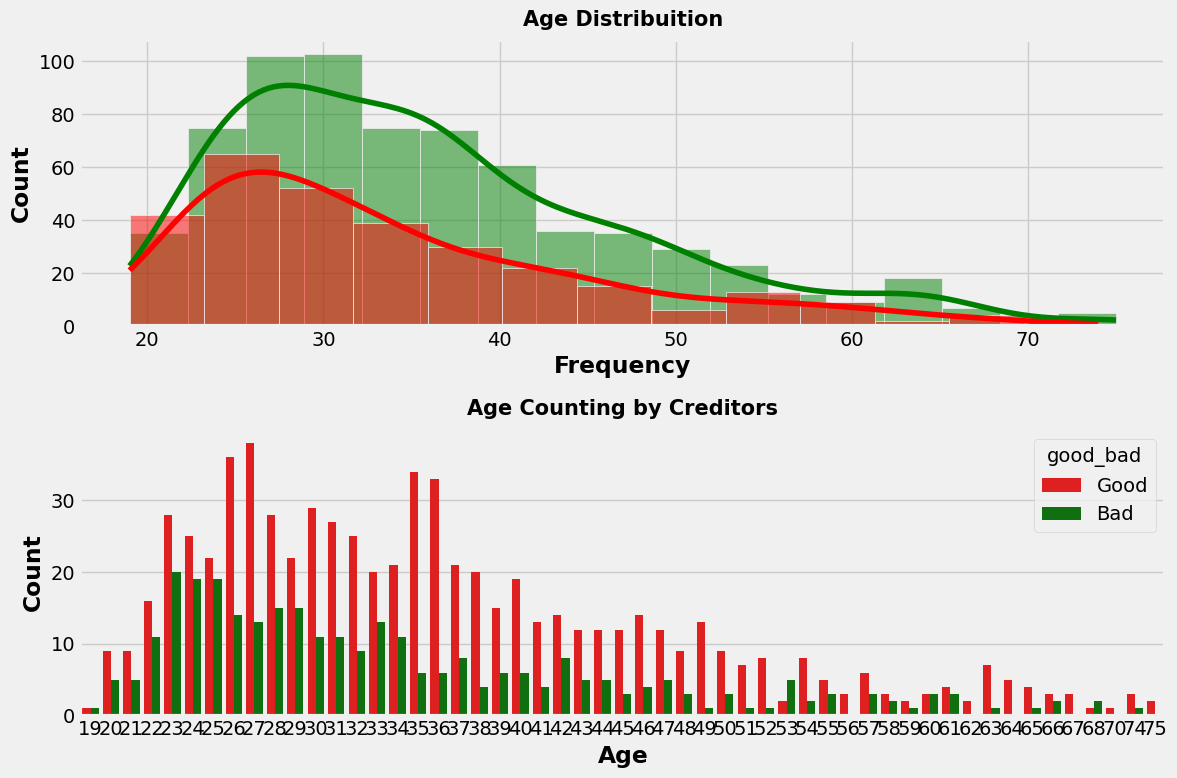

In [7]:
df_good = df_credit[df_credit["good_bad"] == 'Good']
df_bad = df_credit[df_credit["good_bad"] == 'Bad']

fig, ax = plt.subplots(nrows=2, figsize=(12,8))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

g1 = sns.histplot(df_good["Age"], ax=ax[0], color="g", kde=True)
g1 = sns.histplot(df_bad["Age"], ax=ax[0], color='r', kde=True)
g1.set_title("Age Distribuition", fontsize=15)
g1.set_xlabel("Frequency")


g2 = sns.countplot(x="Age",data=df_credit,
              palette=['r',"g"],  
              hue = "good_bad")
g2.set_title("Age Counting by Creditors", fontsize=15)
g2.set_xlabel("Age")
g2.set_ylabel("Count")
plt.show()

### UNIVARIATE ANALYSIS

<Axes: xlabel='Age', ylabel='Count'>

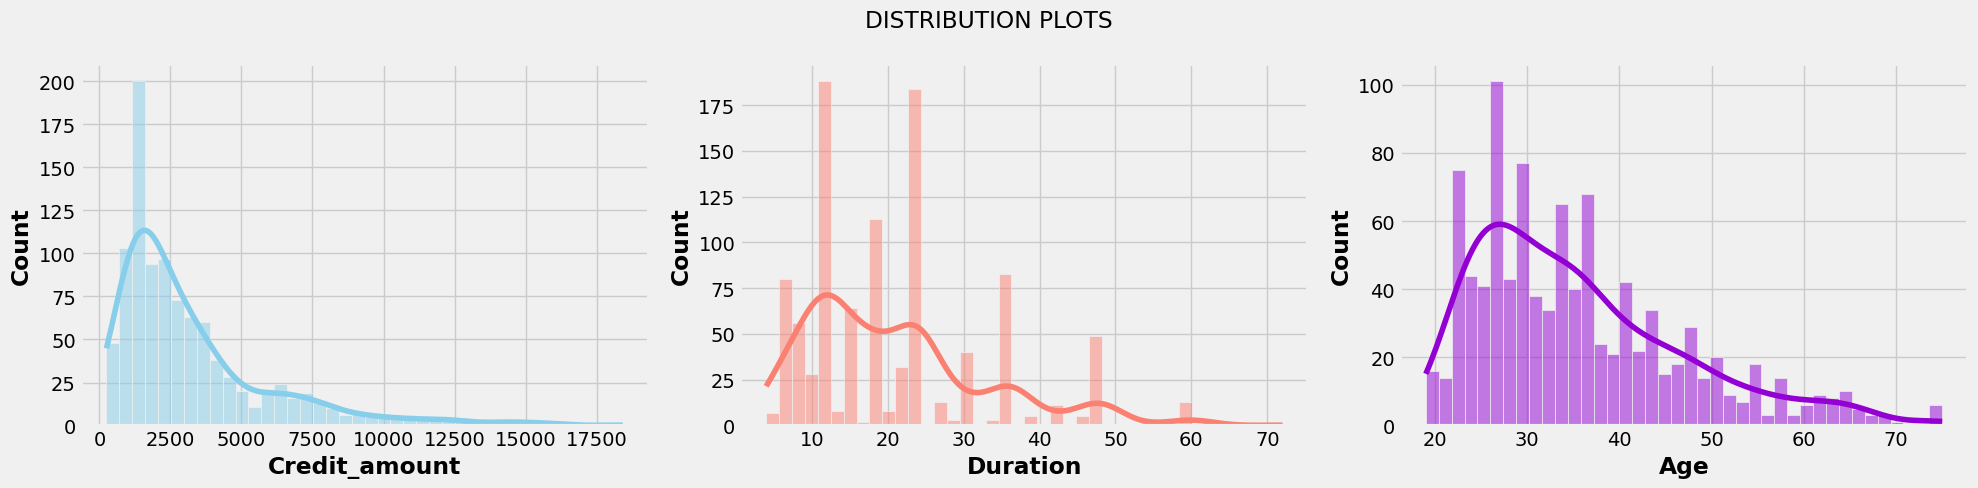

In [8]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
plt.suptitle('DISTRIBUTION PLOTS')
sns.histplot(df_credit['Credit_amount'], bins=40, ax=ax[0], kde=True, color='skyblue')
sns.histplot(df_credit['Duration'], bins=40, ax=ax[1], kde=True, color='salmon')
sns.histplot(df_credit['Age'], bins=40, ax=ax[2], kde=True, color='darkviolet')

### INSIGHTS
---
* Most of the credit cards have an amount of 1500 - 4000
* The Credit amount is positively skewed, So the samples are dispersed

In [9]:
#Show basic stats
df_credit[['Age', 'Duration', 'Credit_amount']].describe()

,Age,Duration,Credit_amount
count,1000.000000,1000.000000,1000.000000
mean,35.546000,20.903000,3271.258000
std,11.375469,12.058814,2822.736876
min,19.000000,4.000000,250.000000
25%,27.000000,12.000000,1365.500000
50%,33.000000,18.000000,2319.500000
75%,42.000000,24.000000,3972.250000
max,75.000000,72.000000,18424.000000


### BIVARIATE ANALYSIS

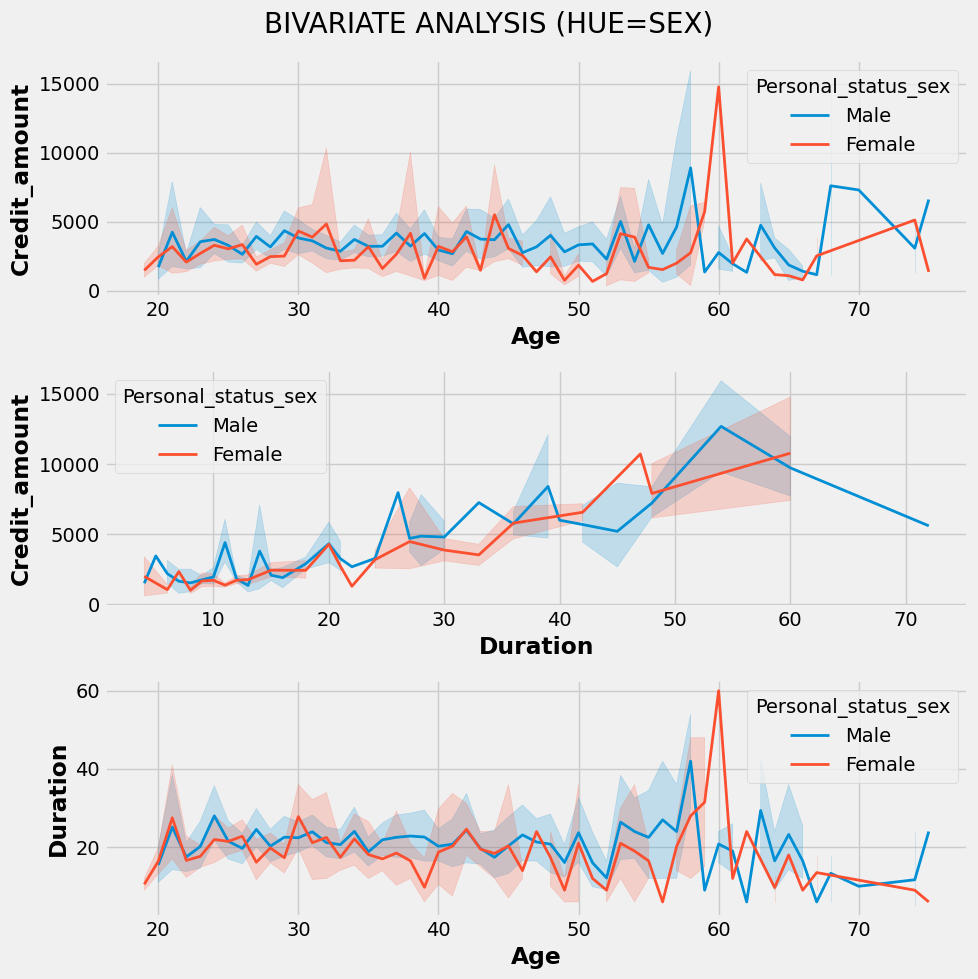

In [10]:
df_credit['Personal_status_sex'] = df_credit['Personal_status_sex'].replace(['A91'],'Male') #A91 : male   : divorced/separated
df_credit['Personal_status_sex'] = df_credit['Personal_status_sex'].replace(['A94'],'Male') #A94 : male   : married/widowed
df_credit['Personal_status_sex'] = df_credit['Personal_status_sex'].replace(['A93'],'Male') #A93 : male   : single
df_credit['Personal_status_sex'] = df_credit['Personal_status_sex'].replace(['A92'],'Female') #A92 : female : divorced/separated/married
df_credit['Personal_status_sex'] = df_credit['Personal_status_sex'].replace(['A95'],'Female') #A95 : female : single
fig, ax = plt.subplots(3,1,figsize=(10,10))
plt.suptitle('BIVARIATE ANALYSIS (HUE=SEX)', fontsize=20)

sns.lineplot(data=df_credit, x='Age', y='Credit_amount', hue='Personal_status_sex', lw=2, ax=ax[0]);
sns.lineplot(data=df_credit, x='Duration', y='Credit_amount', hue='Personal_status_sex', lw=2, ax=ax[1]);
sns.lineplot(data=df_credit, x='Age', y='Duration', hue='Personal_status_sex', lw=2, ax=ax[2]);


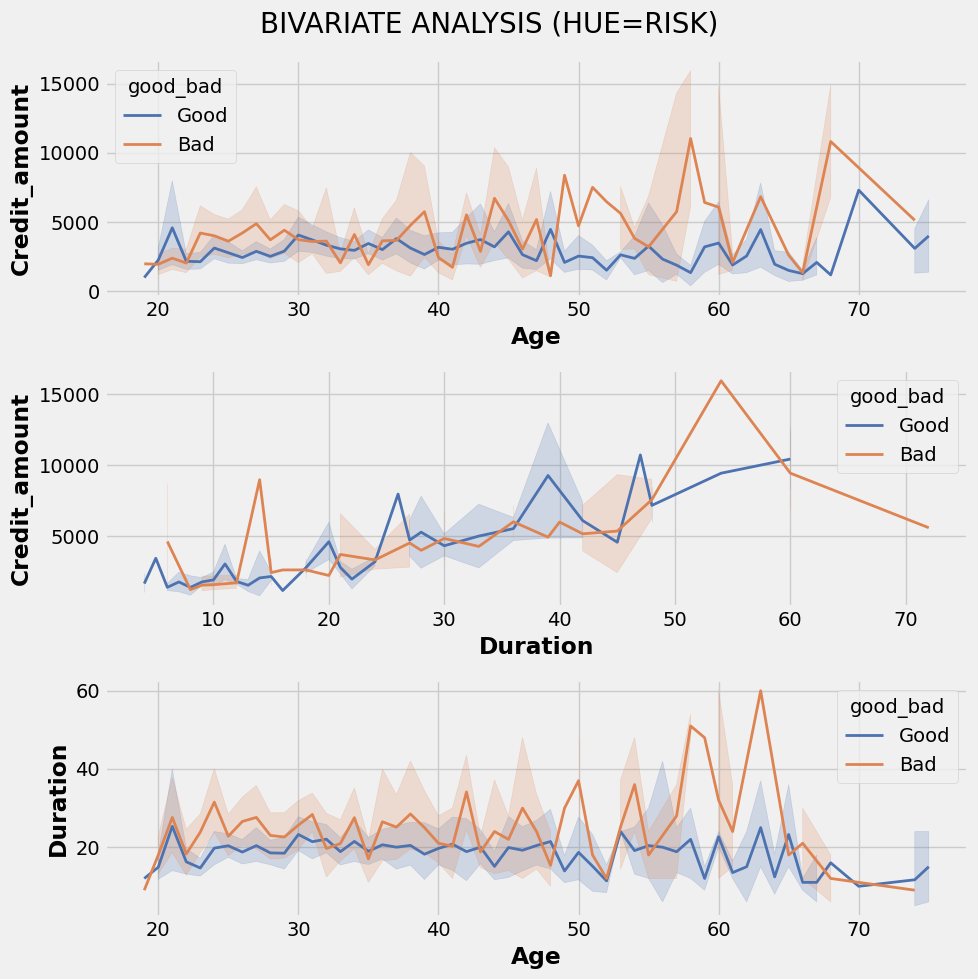

In [11]:
ig, ax = plt.subplots(3,1,figsize=(10,10))
plt.suptitle('BIVARIATE ANALYSIS (HUE=RISK)', fontsize=20)

sns.lineplot(data=df_credit, x='Age', y='Credit_amount', hue='good_bad', lw=2, ax=ax[0], palette='deep');
sns.lineplot(data=df_credit, x='Duration', y='Credit_amount', hue='good_bad', lw=2, ax=ax[1], palette='deep');
sns.lineplot(data=df_credit, x='Age', y='Duration', hue='good_bad', lw=2, ax=ax[2], palette='deep');

### INSIGHTS
---
* There is a linear relationship between Duration and Creadit Amount, Which makes sense because usually, people take bigger credits for longer periods. 
* The trend Between Age and Credit amount is not clear.

### PAIRPLOT TO VISUALIZE FEATURES WITH LINEAR RELATIONSHIP

This is interesting because it made us notice some correlation between **Credit_amount** and **Duration**

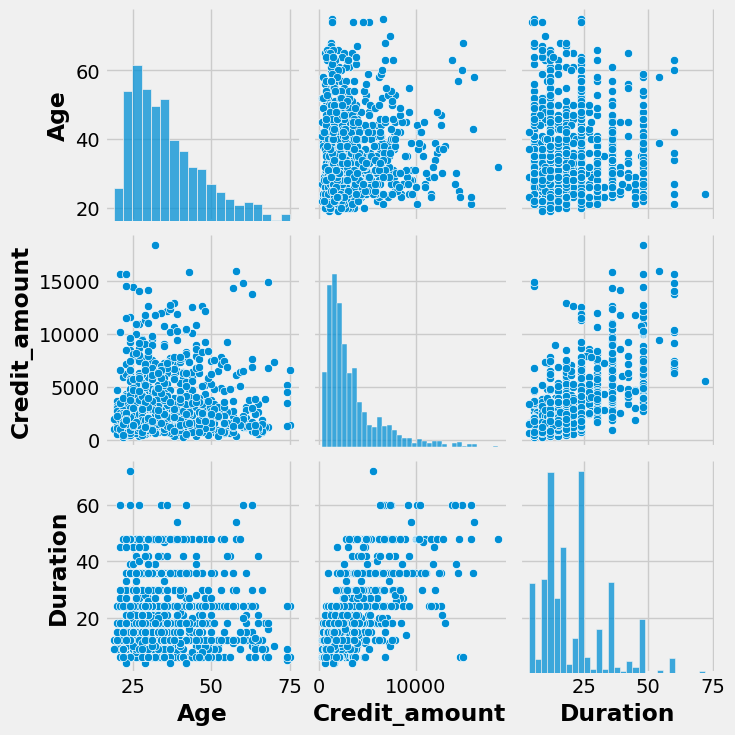

In [12]:
df_credit['Job'] = df_credit['Job'].replace(['A171'],'Unemployed')
df_credit['Job'] = df_credit['Job'].replace(['A172'],'Unskilled')
df_credit['Job'] = df_credit['Job'].replace(['A173'],'Skilled employee')
df_credit['Job'] = df_credit['Job'].replace(['A174'],'Highly qualified employee')
sns.pairplot(df_credit, vars=['Age','Credit_amount','Duration']);

### Credit_Amount - Duration **--> Comparison**

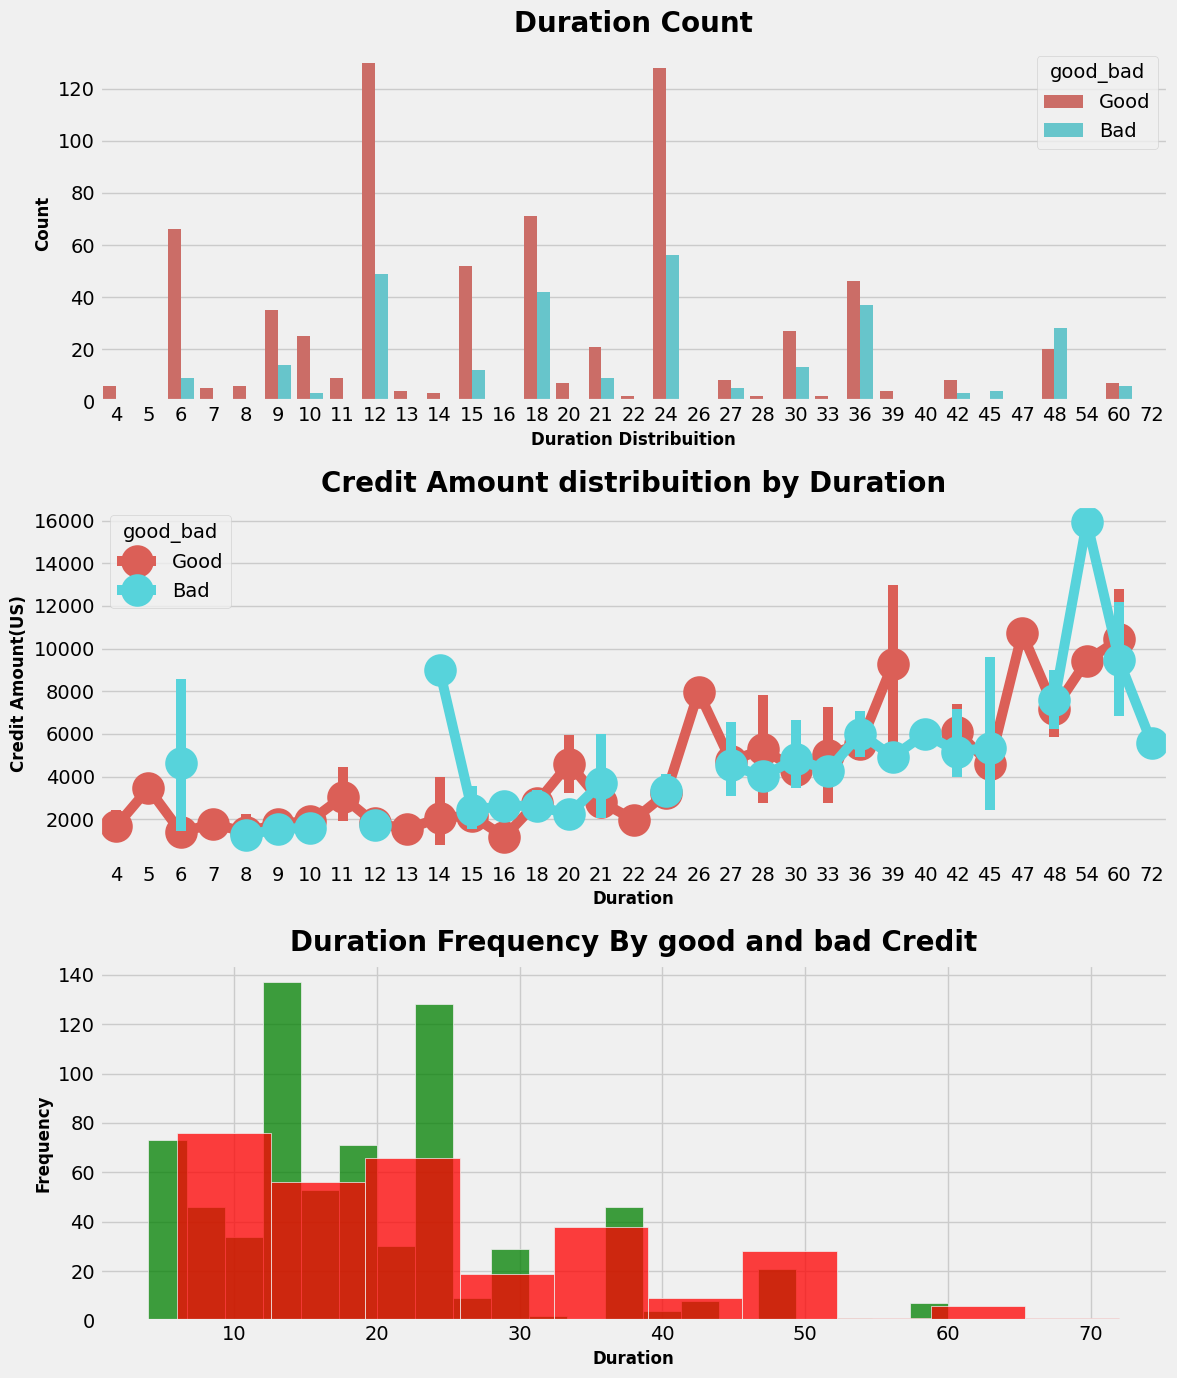

In [13]:
plt.figure(figsize = (12,14))

g= plt.subplot(311)
g = sns.countplot(x="Duration", data=df_credit, 
              palette="hls",  hue = "good_bad")
g.set_xlabel("Duration Distribuition", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Duration Count", fontsize=20)

g1 = plt.subplot(312)
g1 = sns.pointplot(x="Duration", y ="Credit_amount",data=df_credit,
                   hue="good_bad", palette="hls")
g1.set_xlabel("Duration", fontsize=12)
g1.set_ylabel("Credit Amount(US)", fontsize=12)
g1.set_title("Credit Amount distribuition by Duration", fontsize=20)

g2 = plt.subplot(313)
g2 = sns.histplot(df_good["Duration"], color='g')
g2 = sns.histplot(df_bad["Duration"], color='r')
g2.set_xlabel("Duration", fontsize=12)
g2.set_ylabel("Frequency", fontsize=12)
g2.set_title("Duration Frequency By good and bad Credit", fontsize=20)

plt.subplots_adjust(wspace = 0.4, hspace = 0.4,top = 0.9)

plt.show()

## A closer look at this correlation

In [14]:
fig = px.scatter(df_credit, 
                 x='Credit_amount', 
                 y='Duration', 
                 color='good_bad', 
                 opacity=0.8, 
                 hover_data=['Personal_status_sex','Age'], 
                 title='Duration vs. Credit amount')
fig.update_traces(marker_size=5)
fig.show()

### **We tried to emphasize this correlation by adding noise according to the jitter technique**
---
In data exploratory analysis , "jitter" refers to a technique used to add a small amount of random noise to data points in order to prevent overlapping points from obscuring each other. This is particularly useful in visualizations like scatter plots or strip plots where many data points may have identical or similar values, causing them to overlap and making it difficult to see the distribution of the data.


### Why Use Jitter?
1. Prevent Overlapping (Overplotting): When many data points have the same or very similar values, they can overlap on a plot, making it hard to see the true distribution. Jitter spreads these points out slightly, making them more distinguishable.
2. Improved Visualization: By adding jitter, you can better visualize the density and distribution of the data points. This can reveal trends, clusters, and patterns that might be hidden when points are overplotted.
3. Highlight Data Relationships: Jitter can help to highlight relationships and correlations between variables by making it easier to see individual data points and their spread.

### How to Apply Jitter?
Jitter can be applied in various types of plots, such as:
- **Scatter Plots**: Adding jitter to either the x-axis or y-axis (or both) can help distinguish points that would otherwise overlap.
- **Strip Plots**: These plots show individual data points, and adding jitter can prevent them from stacking up on a single line.
- **Box Plots with Data Points**: Adding jitter to the individual data points plotted alongside a box plot helps in seeing the distribution of data within each category.

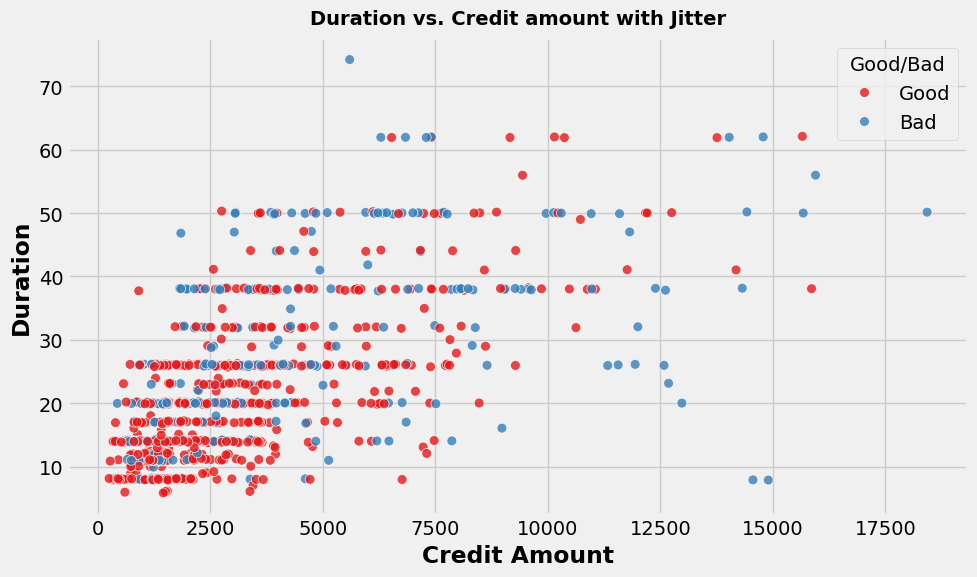

In [15]:
def jitter(values, j):
    return values + np.random.normal(j, 0.1, values.shape)

# Assuming df_credit is your DataFrame containing the data

# Set up the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=jitter(df_credit['Credit_amount'], 2), y=jitter(df_credit['Duration'], 2), hue=df_credit['good_bad'], palette='Set1', alpha=0.8, 
                size=df_credit['good_bad'], sizes=[50, 50])

# Additional customization
plt.title('Duration vs. Credit amount with Jitter')
plt.xlabel('Credit Amount')
plt.ylabel('Duration')
plt.legend(title='Good/Bad', loc='upper right')

plt.show()




### **We have inserted an effect to accentuate the points of greatest density**

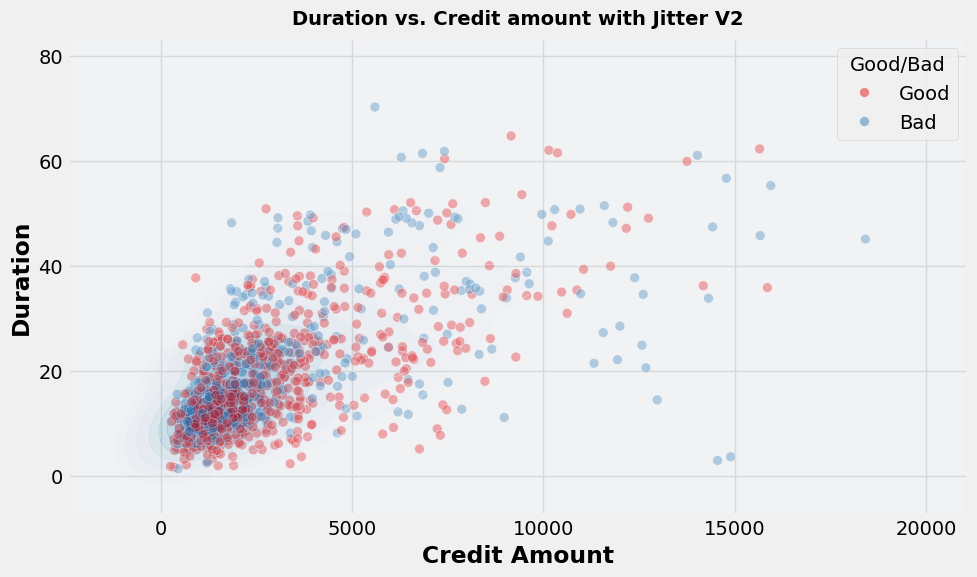

In [16]:
def jitter(values, j):
    return values + np.random.normal(0, j, values.shape)

# Assuming df_credit is your DataFrame containing the data

# Set up the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=jitter(df_credit['Credit_amount'], 2), y=jitter(df_credit['Duration'], 2), hue=df_credit['good_bad'], palette='Set1', alpha=0.5, 
                size=df_credit['good_bad'], sizes=[50, 50])

# Calculate point density
sns.kdeplot(data=df_credit, x='Credit_amount', y='Duration', cmap="Blues", fill=True, thresh=False, alpha=0.3)

# Additional customization
plt.title('Duration vs. Credit amount with Jitter V2')
plt.xlabel('Credit Amount')
plt.ylabel('Duration')
plt.legend(title='Good/Bad', loc='upper right')

plt.show()



## 1.3.2 Categorical Features

### Credit Amount
---
The next 4 plots are a different visualizzation of the Credit_Amount visualization

#### Credit_Amount - Count **--> Comparison**

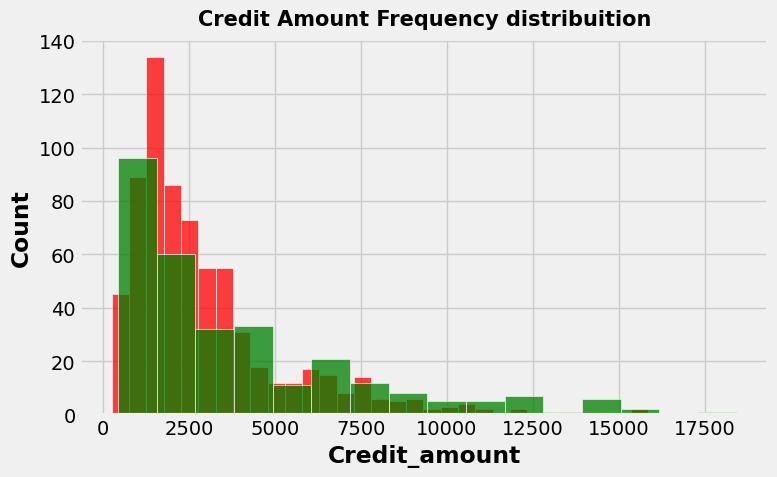

In [17]:
#Ploting the good and bad dataframes in distplot
plt.figure(figsize = (8,5))

g= sns.histplot(df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"], color='r')
g = sns.histplot(df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"], color='g')
g.set_title("Credit Amount Frequency distribuition", fontsize=15)
plt.show()

##### I woul considera a gaussian distribution for plotting Credit_Amount and Count

#### Credit_Amount - Job **--> Comparison**

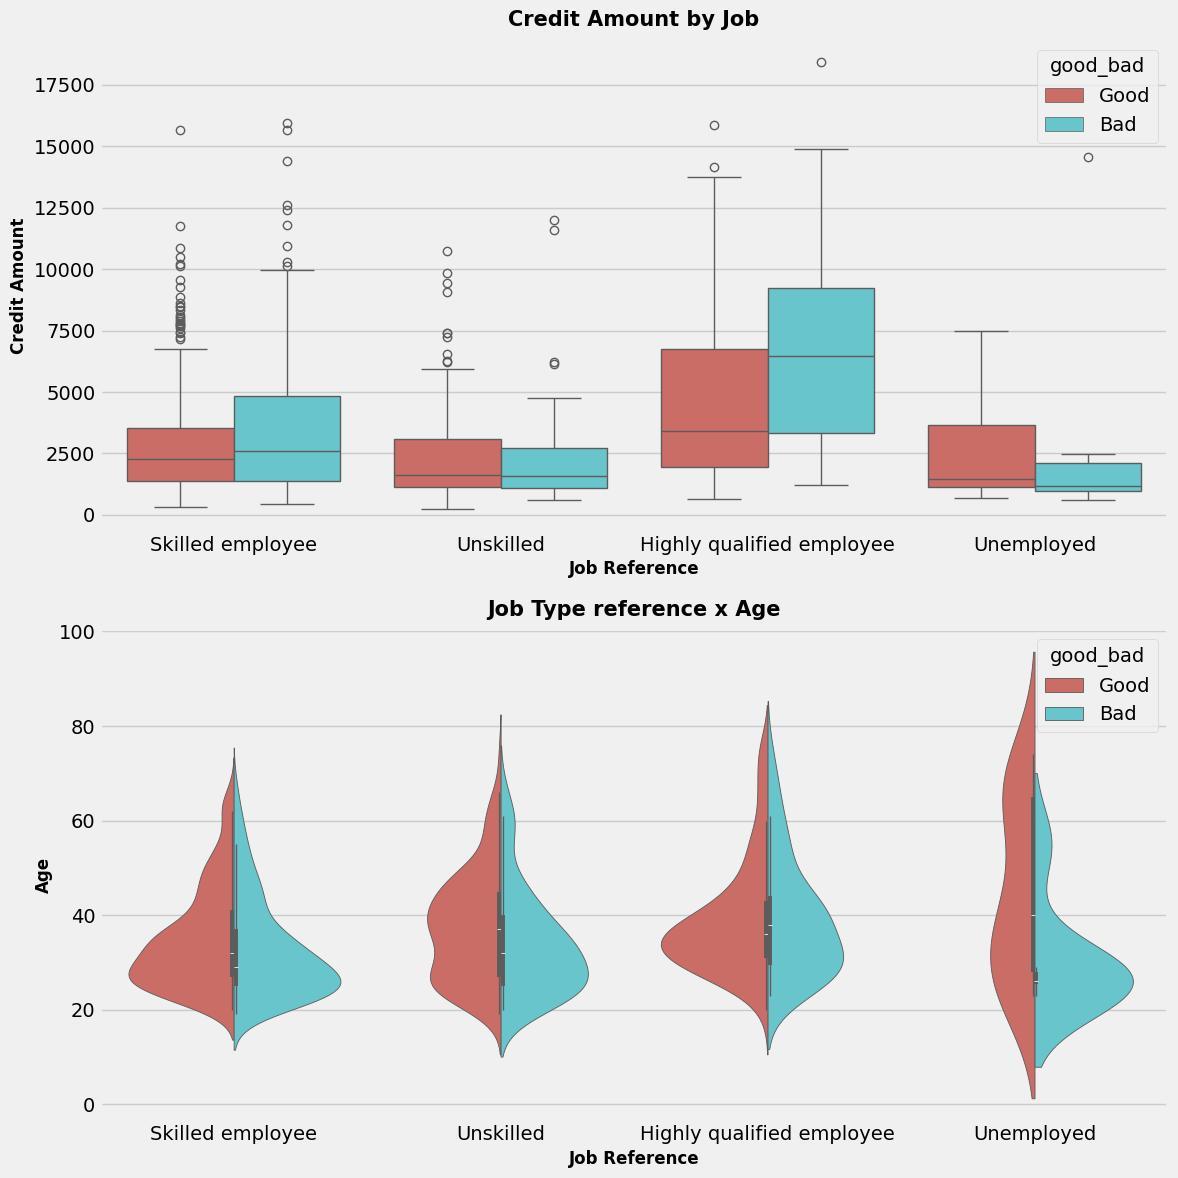

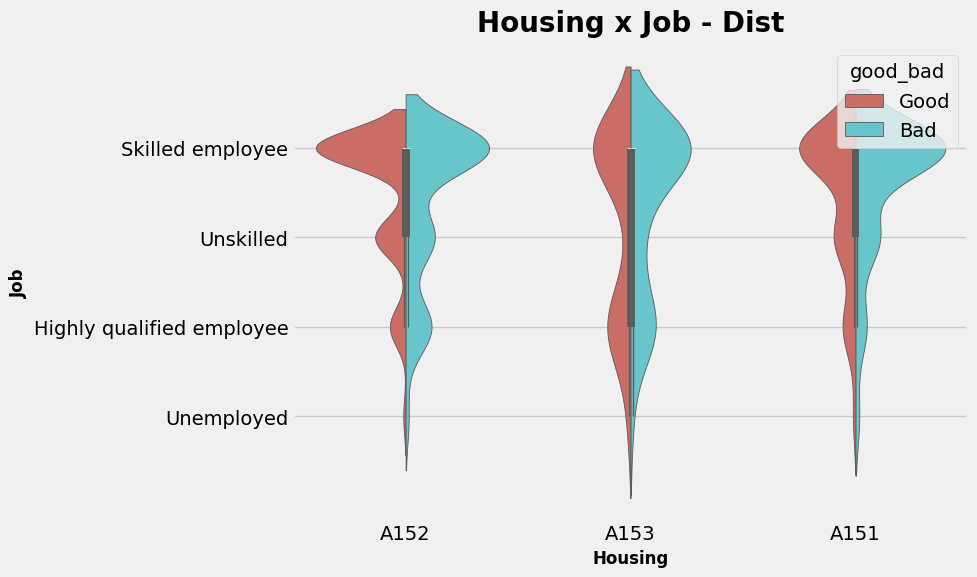

In [18]:
fig, ax = plt.subplots(figsize=(12,12), nrows=2)

g1 = sns.boxplot(x="Job", y="Credit_amount", data=df_credit, 
            palette="hls", ax=ax[0], hue="good_bad")
g1.set_title("Credit Amount by Job", fontsize=15)
g1.set_xlabel("Job Reference", fontsize=12)
g1.set_ylabel("Credit Amount", fontsize=12)

g2 = sns.violinplot(x="Job", y="Age", data=df_credit, ax=ax[1],  
               hue="good_bad", split=True, palette="hls")
g2.set_title("Job Type reference x Age", fontsize=15)
g2.set_xlabel("Job Reference", fontsize=12)
g2.set_ylabel("Age", fontsize=12)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()

###############################################################################################################################################
#Credit Amount by Job (da tenere solo per la relazione perchè è molto chiara)
#Job type reference x Age (da togliere)

trace0 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Good']["Job"],
    y = df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"],
    name='Good credit'
)

trace1 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Job"],
    y = df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"],
    name='Bad credit'
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount distribuition by Job'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

######################################################################################################################################################
# Da utilizzare per fare eventuali considerazioni numeriche, anche se non ne sono troppo sicuro

plt.figure(figsize = (10,6))

g = sns.violinplot(x="Housing",y="Job",data=df_credit,
                   hue="good_bad", palette="hls",split=True)
g.set_xlabel("Housing", fontsize=12)
g.set_ylabel("Job", fontsize=12)
g.set_title("Housing x Job - Dist", fontsize=20)

plt.show()

##################################################################################################################################################


#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Job"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Job"].value_counts().values,
    name='Good credit Distribuition'
)

#Second plot
trace1 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Job"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Job"].value_counts().values,
    name="Bad Credit Distribuition"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Job Distribuition'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='grouped-bar')

## Creating a categorical variable to handle with the Age variable 

In [19]:
#Let's look the Credit Amount column
interval = (19, 25, 35, 50, 70)

cats = ['Senior (35-50)', 'Adult (25-35)', 'Young (19-25)', 'Student (0-19)']
df_credit["Age_cat"] = pd.cut(df_credit.Age, interval, labels=cats) #age_categories


df_good = df_credit[df_credit["good_bad"] == 'Good']
df_bad = df_credit[df_credit["good_bad"] == 'Bad']

###################################################################################################################


trace0 = go.Box(
    y=df_good["Credit_amount"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_bad['Credit_amount'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(
        color='#FF4136'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (Express in US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

## Credit Amount - Housing **--> Comparison**

## I will now Look the distribuition of Housing own and rent by Risk

In [20]:
df_credit['Housing'] = df_credit['Housing'].replace(['A151'],'rent')
df_credit['Housing'] = df_credit['Housing'].replace(['A152'],'own')
df_credit['Housing'] = df_credit['Housing'].replace(['A153'],'free')

#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Housing"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Housing"].value_counts().values,
    name='Good credit'
)

#Second plot
trace1 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Housing"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Housing"].value_counts().values,
    name="Bad Credit"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Housing Distribuition'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='Housing-Grouped')

##################################################################################################################################################
# Maybe we can create a section in which we briefly examinate all the aspect, but in general i don't think this is useful





trace0 = go.Box(
    y=df_credit["Credit_amount"],
    x=df_credit["Housing"],
    name='Good credit',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_credit['Credit_amount'],
    x=df_credit['Housing'],
    name='Bad credit',
    marker=dict(
        color='#FF4136'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (Express in US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
        title='Distribuition of Credit Amount by Housing'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

## Credit Amount - Sex **--> Comparison**

In [21]:
#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Personal_status_sex"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Personal_status_sex"].value_counts().values,
    name='Good credit'
)

#First plot 2
trace1 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Personal_status_sex"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Personal_status_sex"].value_counts().values,
    name="Bad Credit"
)

#Second plot
trace2 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Good']["Personal_status_sex"],
    y = df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"],
    name=trace0.name
)

#Second plot 2
trace3 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Personal_status_sex"],
    y = df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"],
    name=trace1.name
)

data = [trace0, trace1, trace2,trace3]


fig = tls.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Sex Count', 'Credit Amount by Sex'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(height=400, width=800, title='Sex Distribuition', boxmode='group')
py.iplot(fig, filename='sex-subplot')

## Credit Amount - Foreign worker **--> Comparison**

In [22]:
df_credit['foreign_worker'] = df_credit['foreign_worker'].replace(['A201'],'foreign worker')
df_credit['foreign_worker'] = df_credit['foreign_worker'].replace(['A202'],'None foreign worker')

#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["foreign_worker"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["foreign_worker"].value_counts().values,
    name='Good credit'
)

#First plot 2
trace1 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["foreign_worker"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["foreign_worker"].value_counts().values,
    name="Bad Credit"
)

#Second plot
trace2 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Good']["foreign_worker"],
    y = df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"],
    name=trace0.name
)

#Second plot 2
trace3 = go.Box(
    x = df_credit[df_credit["good_bad"]== 'Bad']["foreign_worker"],
    y = df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"],
    name=trace1.name
)

data = [trace0, trace1, trace2,trace3]


fig = tls.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Foreign worker comparison', 'Credit Amount by foreign worker'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(height=400, width=800, title='Foreign worker Distribuition', boxmode='group')
py.iplot(fig, filename='Foreign_worker-subplot')

## Credit Amount - Saving Accounts **--> Comparison**

Description of Distribuition Saving accounts by Risk:  
good_bad               Bad  Good
Savings_account_bonds           
Bad                    217   386
Excellent                6    42
Good                    11    52
Middle                  34    69
No saving account       32   151


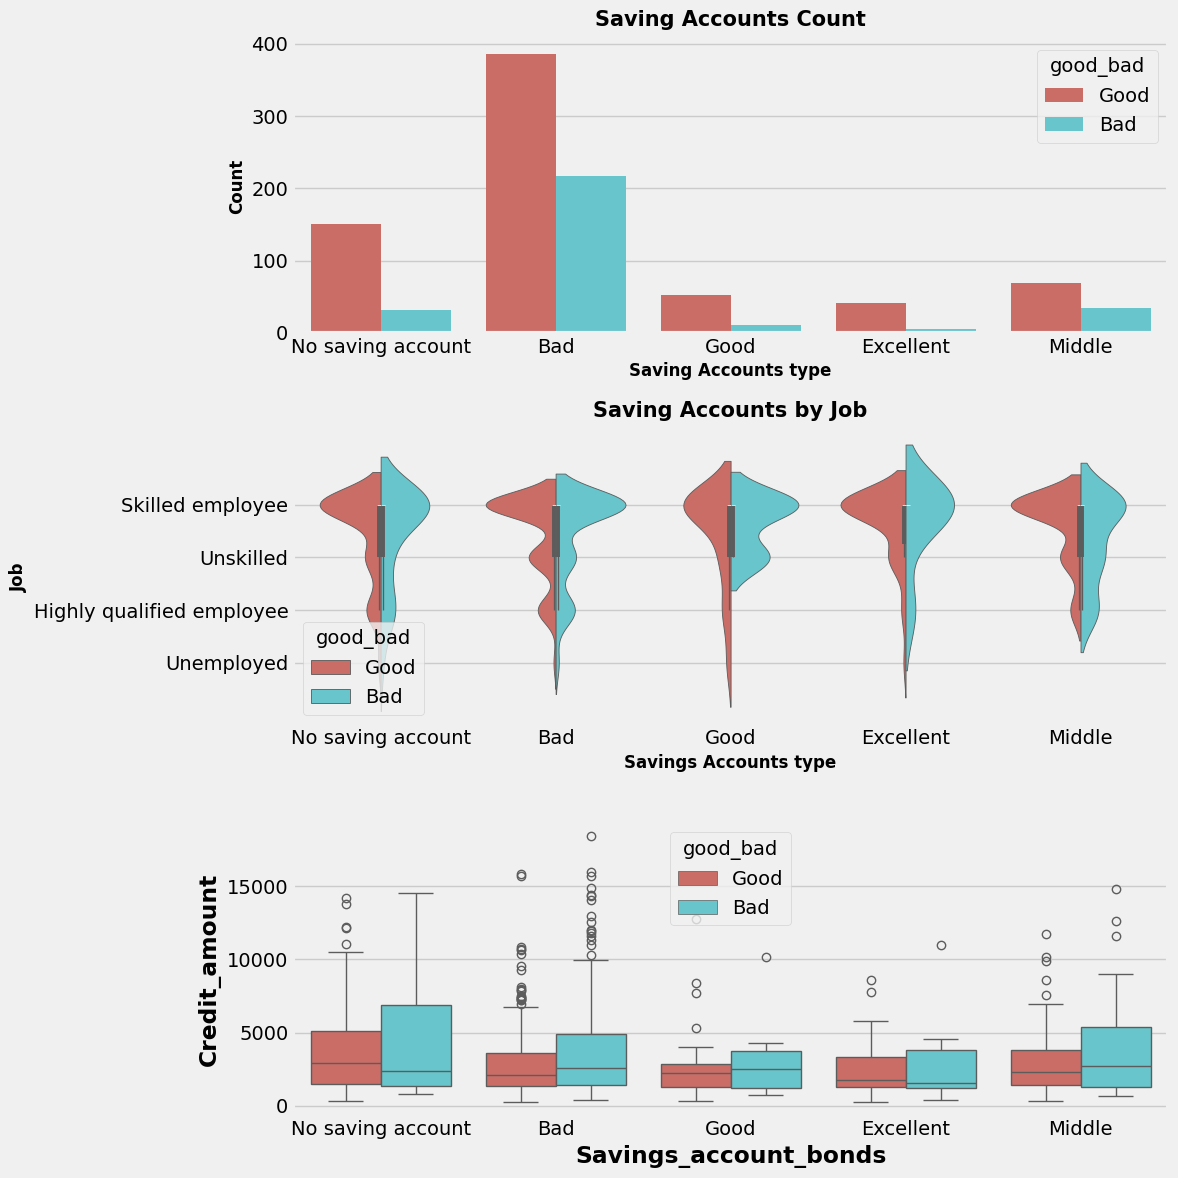

In [23]:
#Attibute 6:  (qualitative)
#	      Savings account/bonds
#	      A61 :          ... <  100 DM Bad
#	      A62 :   100 <= ... <  500 DM Middle
#	      A63 :   500 <= ... < 1000 DM Good
#	      A64 :          .. >= 1000 DM Excellent
#              A65 :   unknown/ no savings account
df_credit['Savings_account_bonds'] = df_credit['Savings_account_bonds'].replace(['A61'],'Bad')
df_credit['Savings_account_bonds'] = df_credit['Savings_account_bonds'].replace(['A62'],'Middle')
df_credit['Savings_account_bonds'] = df_credit['Savings_account_bonds'].replace(['A63'],'Good')
df_credit['Savings_account_bonds'] = df_credit['Savings_account_bonds'].replace(['A64'],'Excellent')
df_credit['Savings_account_bonds'] = df_credit['Savings_account_bonds'].replace(['A65'],'No saving account')

count_good = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Savings_account_bonds"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Savings_account_bonds"].value_counts().values,
    name='Good credit'
)
count_bad = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Savings_account_bonds"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Savings_account_bonds"].value_counts().values,
    name='Bad credit'
)


box_1 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Good']["Savings_account_bonds"],
    y=df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"],
    name='Good credit'
)
box_2 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Bad']["Savings_account_bonds"],
    y=df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"],
    name='Bad credit'
)

scat_1 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Good']["Savings_account_bonds"],
    y=df_credit[df_credit["good_bad"]== 'Good']["Age"],
    name='Good credit'
)
scat_2 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Bad']["Savings_account_bonds"],
    y=df_credit[df_credit["good_bad"]== 'Bad']["Age"],
    name='Bad credit'
)

data = [scat_1, scat_2, box_1, box_2, count_good, count_bad]

fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Count Saving Accounts','Credit Amount by Savings Acc', 
                                          'Age by Saving accounts'))

fig.append_trace(count_good, 1, 1)
fig.append_trace(count_bad, 1, 1)

fig.append_trace(box_2, 1, 2)
fig.append_trace(box_1, 1, 2)

fig.append_trace(scat_1, 2, 1)
fig.append_trace(scat_2, 2, 1)



fig['layout'].update(height=700, width=800, title='Saving Accounts Exploration', boxmode='group')

py.iplot(fig, filename='combined-savings')


######################################################################################################################################################
#Also here, i would consider "Credit Amount by Savings Acc" but the others i don't think they're interesting

print("Description of Distribuition Saving accounts by Risk:  ")
print(pd.crosstab(df_credit["Savings_account_bonds"],df_credit.good_bad))

fig, ax = plt.subplots(3,1, figsize=(12,12))
g = sns.countplot(x="Savings_account_bonds", data=df_credit, palette="hls", 
              ax=ax[0],hue="good_bad")
g.set_title("Saving Accounts Count", fontsize=15)
g.set_xlabel("Saving Accounts type", fontsize=12)
g.set_ylabel("Count", fontsize=12)

g1 = sns.violinplot(x="Savings_account_bonds", y="Job", data=df_credit, palette="hls", 
               hue = "good_bad", ax=ax[1],split=True)
g1.set_title("Saving Accounts by Job", fontsize=15)
g1.set_xlabel("Savings Accounts type", fontsize=12)
g1.set_ylabel("Job", fontsize=12)

g = sns.boxplot(x="Savings_account_bonds", y="Credit_amount", data=df_credit, ax=ax[2],
            hue = "good_bad",palette="hls")
g2.set_title("Saving Accounts by Credit Amount", fontsize=15)
g2.set_xlabel("Savings Accounts type", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()


########################################################################
# The last image is exactly the same as the last previouse one "Credit Account by saving account", so as before
# Quella con cui si può interagire (che restituire min, max, mean, ecc...) la possiamo usare per fare delle considerazioni nella relazione.
# Mentre quella quì in basso la possiamo usare per visualizzare meglio gli outliers



## Credit Amount - Status Accounts **--> Comparison**

Description of Distribuition Status accounts by Risk:  
good_bad        Bad  Good
Status_account           
In Debt         135   139
Normal          105   164
Rich             14    49
Uknown           46   348


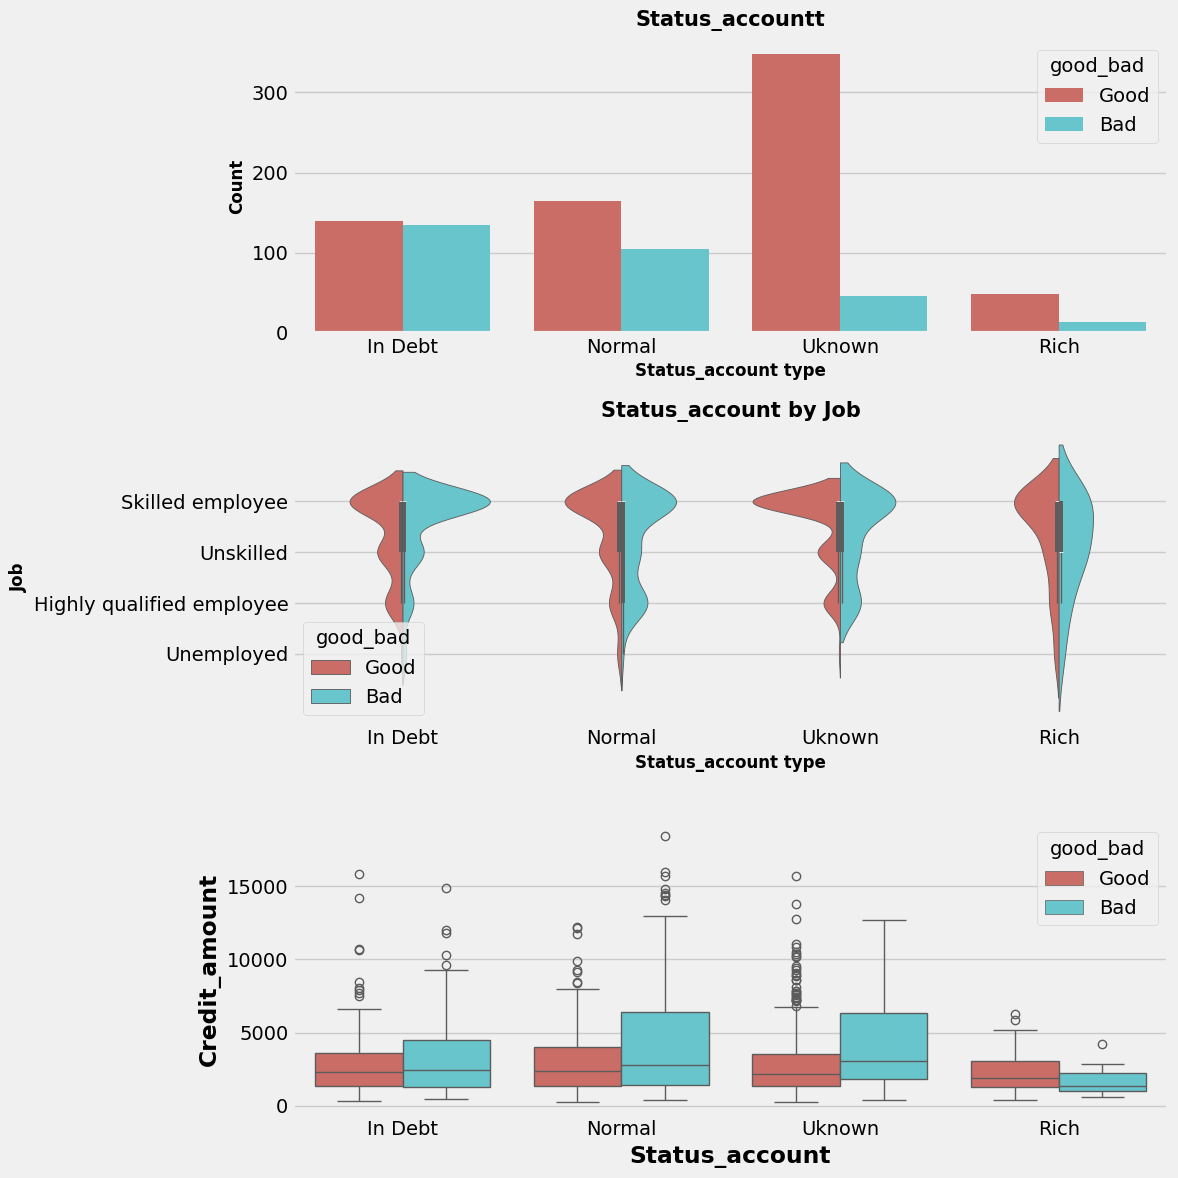

In [24]:
#Attribute 1:  (qualitative)
#	       Status of existing checking account
#               A11 :      ... <    0 DM
#	       A12 : 0 <= ... <  200 DM
#	       A13 :      ... >= 200 DM /
#		     salary assignments for at least 1 year
#               A14 : no checking account

df_credit['Status_account'] = df_credit['Status_account'].replace(['A11'],'In Debt')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A12'],'Normal')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A13'],'Rich')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A14'],'Uknown')


count_good = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Status_account"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Status_account"].value_counts().values,
    name='Good credit'
)
count_bad = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Status_account"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Status_account"].value_counts().values,
    name='Bad credit'
)


box_1 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Good']["Status_account"],
    y=df_credit[df_credit["good_bad"]== 'Good']["Credit_amount"],
    name='Good credit'
)
box_2 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Bad']["Status_account"],
    y=df_credit[df_credit["good_bad"]== 'Bad']["Credit_amount"],
    name='Bad credit'
)

scat_1 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Good']["Status_account"],
    y=df_credit[df_credit["good_bad"]== 'Good']["Age"],
    name='Good credit'
)
scat_2 = go.Box(
    x=df_credit[df_credit["good_bad"]== 'Bad']["Status_account"],
    y=df_credit[df_credit["good_bad"]== 'Bad']["Age"],
    name='Bad credit'
)

data = [scat_1, scat_2, box_1, box_2, count_good, count_bad]

fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Status_account','Credit Amount by Status_account', 
                                          'Age by Status_account'))

fig.append_trace(count_good, 1, 1)
fig.append_trace(count_bad, 1, 1)

fig.append_trace(box_2, 1, 2)
fig.append_trace(box_1, 1, 2)

fig.append_trace(scat_1, 2, 1)
fig.append_trace(scat_2, 2, 1)



fig['layout'].update(height=700, width=800, title='Status_account Exploration', boxmode='group')

py.iplot(fig, filename='combined-statusAccount')

print("Description of Distribuition Status accounts by Risk:  ")
print(pd.crosstab(df_credit["Status_account"],df_credit.good_bad))

fig, ax = plt.subplots(3,1, figsize=(12,12))
g = sns.countplot(x="Status_account", data=df_credit, palette="hls", 
              ax=ax[0],hue="good_bad")
g.set_title("Status_accountt", fontsize=15)
g.set_xlabel("Status_account type", fontsize=12)
g.set_ylabel("Count", fontsize=12)

g1 = sns.violinplot(x="Status_account", y="Job", data=df_credit, palette="hls", 
               hue = "good_bad", ax=ax[1],split=True)
g1.set_title("Status_account by Job", fontsize=15)
g1.set_xlabel("Status_account type", fontsize=12)
g1.set_ylabel("Job", fontsize=12)

g = sns.boxplot(x="Status_account", y="Credit_amount", data=df_credit, ax=ax[2],
            hue = "good_bad",palette="hls")
g2.set_title("Status Accounts by Credit Amount", fontsize=15)
g2.set_xlabel("Status Accounts type", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()


## Credit_Amount - Purpose **--> Comparison**

Values describe: 
good_bad      Bad  Good
Purpose                
Business       34    63
Domestic App    4     8
Education      22    28
Furniture      58   123
New Car        89   145
Others          5     7
Radio/TV       62   218
Repairs         8    14
Retraining      1     8
Used Car       17    86


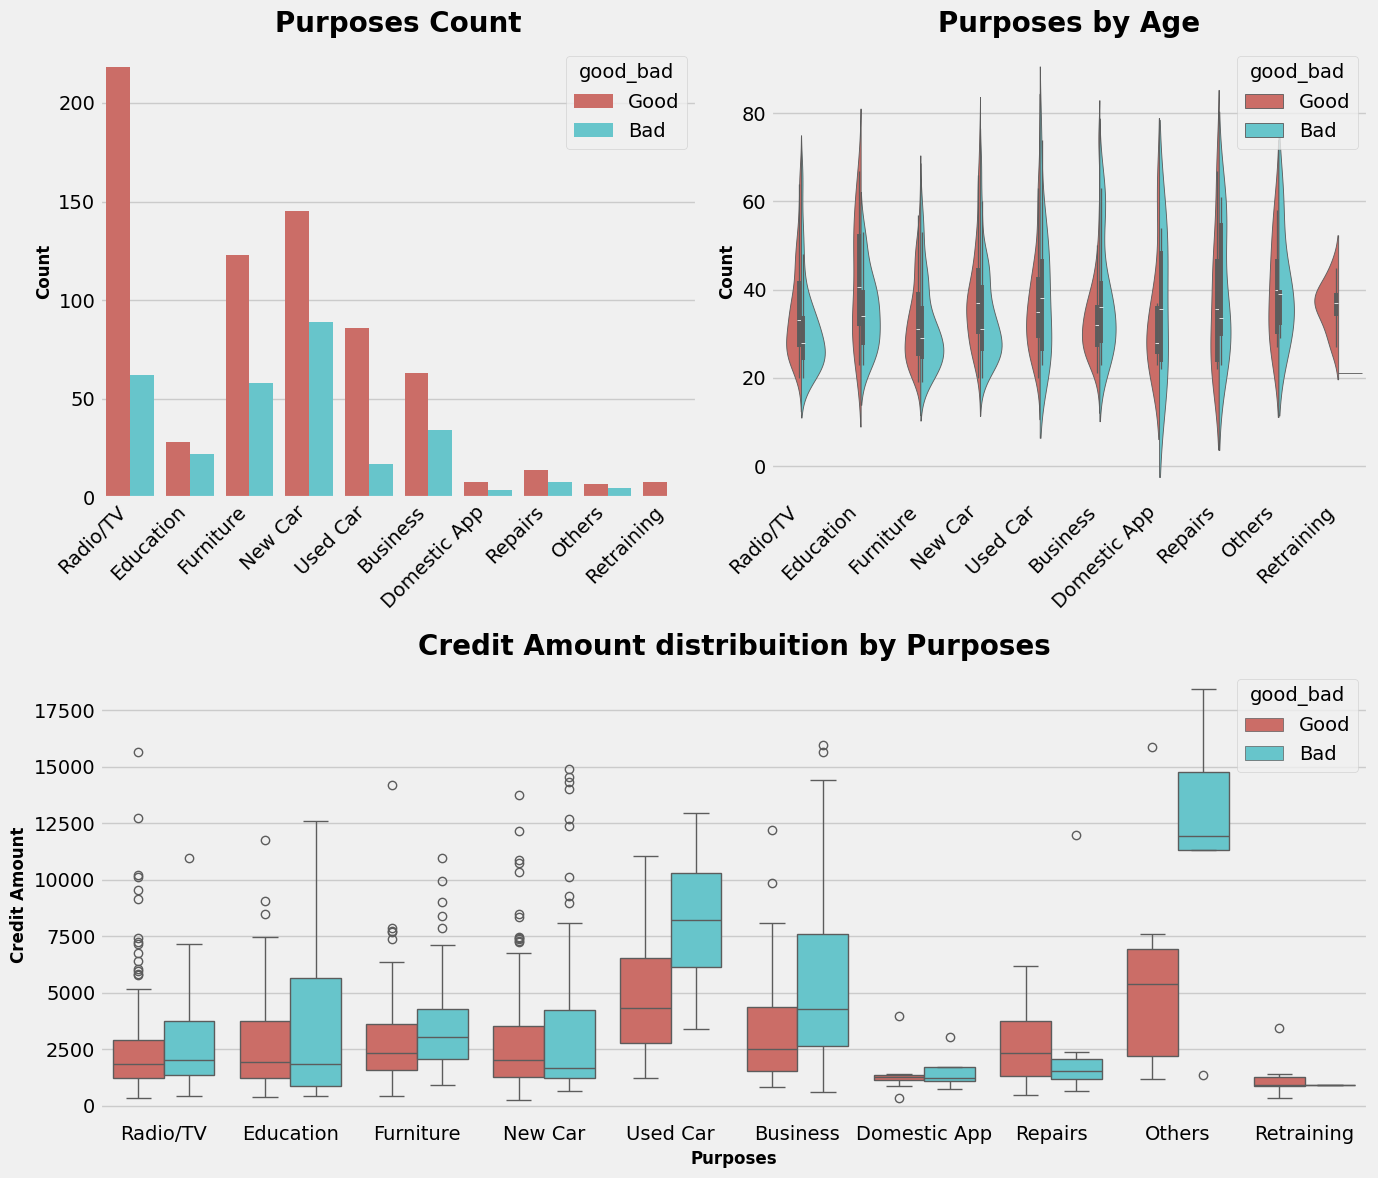

In [25]:
df_credit['Purpose'] = df_credit['Purpose'].replace(['A40'],'New Car')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A41'],'Used Car')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A42'],'Furniture')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A43'],'Radio/TV')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A44'],'Domestic App')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A45'],'Repairs')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A46'],'Education')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A47'],'Vacation')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A48'],'Retraining')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A49'],'Business')
df_credit['Purpose'] = df_credit['Purpose'].replace(['A410'],'Others')
print("Values describe: ")
print(pd.crosstab(df_credit.Purpose, df_credit.good_bad))

plt.figure(figsize = (14,12))


plt.subplot(221)
g = sns.countplot(x="Purpose", data=df_credit, 
              palette="hls", hue = "good_bad")
g.set_xticks(g.get_xticks())
g.set_xticklabels(g.get_xticklabels(),rotation=45, ha="right")
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Purposes Count", fontsize=20)

plt.subplot(222)
g1 = sns.violinplot(x="Purpose", y="Age", data=df_credit, 
                    palette="hls", hue = "good_bad",split=True)
g1.set_xticks(g1.get_xticks())
g1.set_xticklabels(g1.get_xticklabels(),rotation=45, ha="right")
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Purposes by Age", fontsize=20)

plt.subplot(212)
g2 = sns.boxplot(x="Purpose", y="Credit_amount", data=df_credit, 
               palette="hls", hue = "good_bad")
g2.set_xticks(g2.get_xticks())
g2.set_xlabel("Purposes", fontsize=12)
g2.set_ylabel("Credit Amount", fontsize=12)
g2.set_title("Credit Amount distribuition by Purposes", fontsize=20)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

## Status Account variable

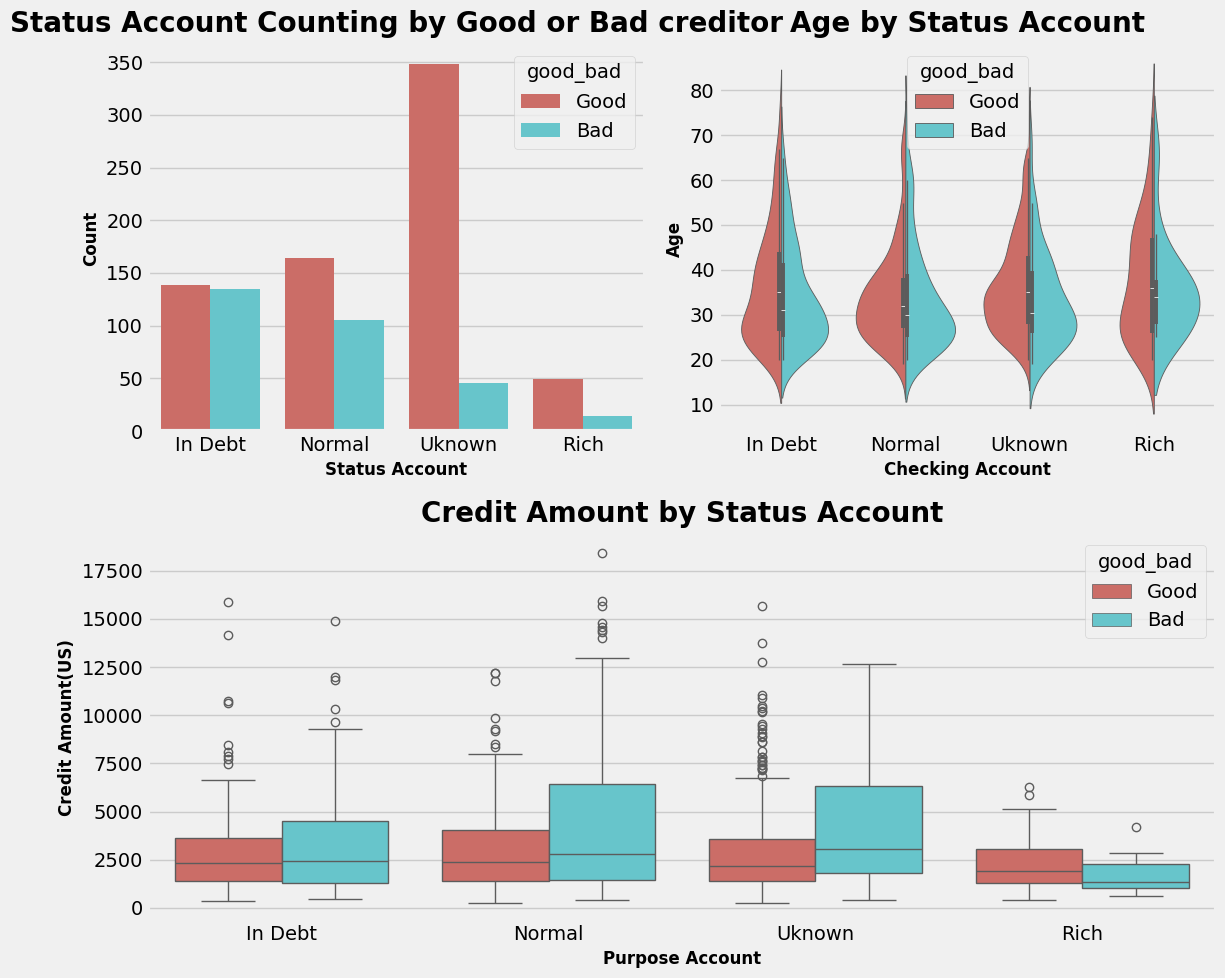

In [26]:
df_credit['Status_account'] = df_credit['Status_account'].replace(['A11'],'In Debt')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A12'],'Moderate')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A13'],'Rich')
df_credit['Status_account'] = df_credit['Status_account'].replace(['A14'],'No checking')

#First plot
trace0 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Good']["Status_account"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Good']["Status_account"].value_counts().values,
    name='Good credit Distribuition' 
    
)

#Second plot
trace1 = go.Bar(
    x = df_credit[df_credit["good_bad"]== 'Bad']["Status_account"].value_counts().index.values,
    y = df_credit[df_credit["good_bad"]== 'Bad']["Status_account"].value_counts().values,
    name="Bad Credit Distribuition"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Status accounts Distribuition',
    xaxis=dict(title='Status accounts name'),
    yaxis=dict(title='Count'),
    barmode='group'
)


fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename = 'Age-ba', validate = False)

trace0 = go.Box(
    y=df_credit[df_credit["good_bad"] == 'Good']["Credit_amount"],
    x=df_credit[df_credit["good_bad"] == 'Good']["Status_account"],
    name='Good credit',
    marker=dict(
        color='#3D9970'
    )
)

trace1 = go.Box(
    y=df_credit[df_credit["good_bad"] == 'Bad']['Credit_amount'],
    x=df_credit[df_credit["good_bad"] == 'Bad']['Status_account'],
    name='Bad credit',
    marker=dict(
        color='#FF4136'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Status distribuition'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

##################################################
plt.figure(figsize = (12,10))

g = plt.subplot(221)
g = sns.countplot(x="Status_account", data=df_credit, 
              palette="hls", hue="good_bad")
g.set_xlabel("Status Account", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Status Account Counting by Good or Bad creditor", fontsize=20)

g1 = plt.subplot(222)
g1 = sns.violinplot(x="Status_account", y="Age", data=df_credit, palette="hls", hue = "good_bad",split=True)
g1.set_xlabel("Checking Account", fontsize=12)
g1.set_ylabel("Age", fontsize=12)
g1.set_title("Age by Status Account", fontsize=20)

g2 = plt.subplot(212)
g2 = sns.boxplot(x="Status_account",y="Credit_amount", data=df_credit,hue='good_bad',palette="hls")
g2.set_xlabel("Purpose Account", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)
g2.set_title("Credit Amount by Status Account", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.3, top = 0.9)

plt.show()

### Some numerical date
---

In [27]:
print(pd.crosstab(df_credit.Personal_status_sex, df_credit.Job))

Job                  Highly qualified employee  Skilled employee  Unemployed  \
Personal_status_sex                                                            
Female                                      37               197          12   
Male                                       111               433          10   

Job                  Unskilled  
Personal_status_sex             
Female                      64  
Male                       136  


In [28]:
print(pd.crosstab(df_credit["Status_account"],df_credit.Personal_status_sex))

Personal_status_sex  Female  Male
Status_account                   
In Debt                  88   186
Normal                   86   183
Rich                     20    43
Uknown                  116   278


In [29]:
print(pd.crosstab(df_credit["Purpose"],df_credit.Personal_status_sex))

Personal_status_sex  Female  Male
Purpose                          
Business                 19    78
Domestic App              6     6
Education                21    29
Furniture                74   107
New Car                  70   164
Others                    3     9
Radio/TV                 85   195
Repairs                   5    17
Retraining                3     6
Used Car                 24    79


### Result in brief
---

The relevant details extracted from this analysis include the correlation between Duration and Credit Amount, which we examine in detail using the jitter technique, and the significant disparity between good and bad creditors in the dataset. This disparity makes it challenging to determine which category is more relevant in terms of results. It is important to note that any observed imbalance cannot be specifically attributed to a particular category but rather to the overall imbalance between good and bad creditors within the database.